Name: Antony Krymski

Username: agk-123

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import keras

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [78]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def label_bounds(v, delta):
    # return binary 0,1 if v moves up or down by delta
    Y = np.zeros(len(v))
    count = len(v)
    for i in range(0, count):
        p = v[i]
        for j in range(i + 1, count):
            d = (v[j] - p)
            if d <= (delta[i]*-1):
                Y[i] = 0.
                break
            if d >= delta[i]:
                Y[i] = 1.
                break
    return Y

def apply_padding(img, n):
    height, width, channels = img.shape
    n_top = np.random.randint(0,n)
    n_bottom = n - n_top
    top = np.zeros((n_top, width, channels), dtype=np.uint8)
    bottom = np.zeros((n_bottom, width, channels), dtype=np.uint8)
    return np.vstack((top, img, bottom))

def draw(img, arr, value=1):
    height = img.shape[0]
    xs = np.arange(arr.shape[0])
    ys = np.round(arr * (height-1)).astype(np.int64)
    img[height-ys-1, xs] = value
    return img

def scale(a):
    maxv = np.max(a)
    minv = np.min(a)
    if maxv == minv:
        return a - minv
    return (a - minv) / (maxv - minv)

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(len(X) * (1 - test_size))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def plot_training(history):
    # Plot the training and validation loss
    plt.figure(figsize=(14, 7))
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot(x):
    plt.figure(figsize=(14, 7))
    plt.plot(x)
    plt.show()

def returns(a):
    a = np.log(a)
    return np.diff(a, axis=0)
    
def synthetic(N, freq=4, noise=0.2):
    length = np.pi * freq
    data = np.sin(np.arange(0, length, length / N)) + 100.
    data += np.random.normal(0, noise, data.shape)
    # data += np.linspace(0, 10, N)
    return np.expand_dims(data, 1)

def load_data():
    df = pd.read_hdf('~/dev/tensorcap2/data.h5', 'SPY')
    df.index = pd.to_datetime(df.index, unit='s')
    # df = np.rint(df * 100).astype(np.int32)
    return df[['Close']].values.astype(np.float32)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

# Data

# Pre-processing

In [79]:
# SPX = download()
# SPX.head()

VIX = download('^VIX')
VIX.head()
VIX.dropna(inplace=True)

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [80]:
timesteps = 250
height = 16
n_windows = 1
features = 1
code_size = 32
batch_size = 16
input_shape = (n_windows, height, timesteps, 1)

(8723, 1)


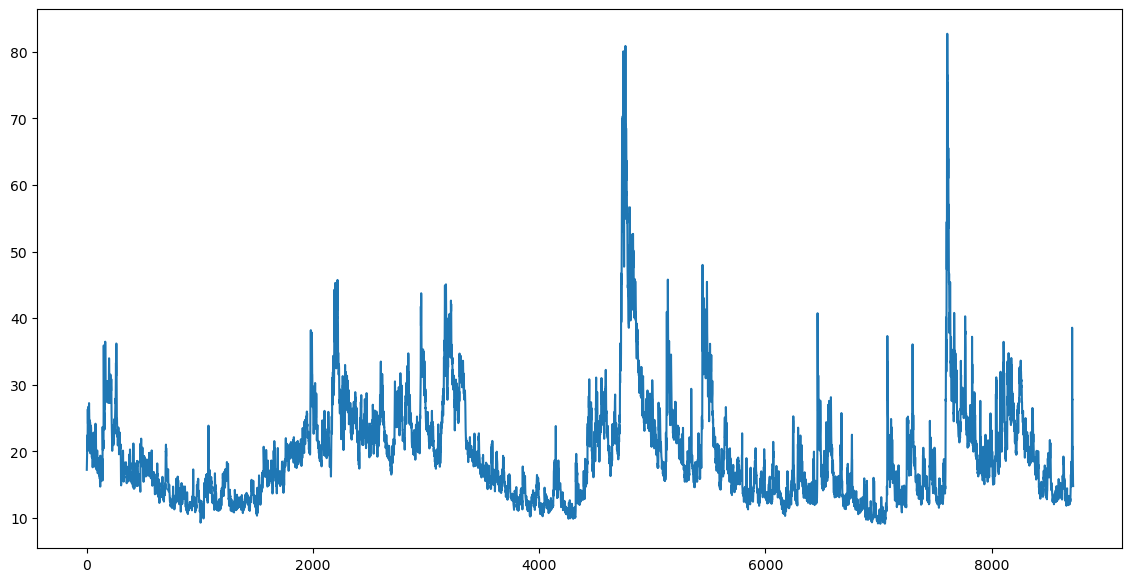

In [44]:
# X = synthetic(10000, 8, .01)
X = VIX[['Close']].values
assert(np.isfinite(X).all() == True)
print(X.shape)
plot(X)

In [45]:
# compute log returns with a given forecast horizon
y = pd.Series(np.log(X[:, 0])).diff(1).shift(-1).values
# y = label_bounds(df['Close'].values, df['Close'].ewm(span=28, min_periods=28).std().values)
y = y.astype(np.float32)
y = np.where(y > 0, 1., 0)

# Make data stationary using log returns
# X[:, 0] = pd.Series(np.log(X[:, 0])).diff().values

X = X[1:-timesteps]
y = y[1:-timesteps]

# remove outliers
# outliers = np.quantile(np.abs(X), 0.999)
# X = np.clip(X, -outliers, outliers)

# scale
# X = X / np.max(np.abs(X))

x_train, x_test, y_train, y_test = split(X, y, 0.25)

print('y_train baseline: ', len(np.where(y_train > 0)[0]) / len(y_train))
print('y_test baseline: ', len(np.where(y_test > 0)[0]) / len(y_test))

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(X).all() == True)
assert(np.isfinite(y).all() == True)

y_train baseline:  0.4711992445703494
y_test baseline:  0.4523135033050047
(6354, 1) (2118, 1)
(6354,) (2118,)


# Data Generation

In [46]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=timesteps, n_windows=n_windows, height=height):
        self.height = height
        self.timesteps = timesteps
        self.n_windows = n_windows
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * n_windows) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        x = self.data[idx:idx+self.timesteps, 0]
        x = scale(x)
        img = np.zeros((self.height-4, self.timesteps, 1))
        img = draw(img, x)
        img = apply_padding(img, 4)
        return img

    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            windows = []
            for w in range(self.n_windows):
                windows.append(self.get_window(idx + (w * self.timesteps)))

            y_positive = self.get_window(idx + (self.n_windows * self.timesteps))
            y_negative = self.get_window(np.random.choice(indexes))

            # # augment with random image flipping
            # if np.random.rand() < 0.5:
            #     y_negative = np.flipud(y_negative)
            # if np.random.rand() < 0.5:
            #     y_negative = np.fliplr(y_negative)

            # positive sample
            x.append(windows)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(windows)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        # labels = np.expand_dims(np.array(labels), axis=-1)
        labels = np.array(labels).astype(np.float32)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [47]:
dg = DataGenerator(x_train, batch_size=16, shuffle=False)

print(len(dg))

# get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

365
x shape: (16, 1, 16, 250, 1), y shape: (16, 16, 250, 1), labels shape: (16,)


# Inspecting Windows

[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]


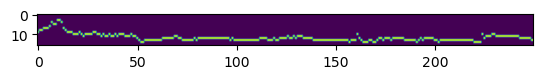

In [48]:
plt.imshow(by[0])
print(labels)

# Model Architecture

In [49]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv2D(16, 3, activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2, 4))(x)
    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 4))(x)
    # x = BatchNormalization()(x)
    x = Flatten()(x)
    # x = Dropout(0.5)(x)
    # x = Dense(32, activation='linear')(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder(input_shape[1:], code_size)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 250, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 250, 16)       160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 62, 16)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 62, 16)         2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 15, 16)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 960)               0   

In [50]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    # x = GRU(128, return_sequences=False, name="context")(input)
    x = LSTM(128, return_sequences=False, name="context")(input)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((timesteps, code_size), code_size)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 250, 32)]         0         
                                                                 
 context (LSTM)              (None, 128)               82432     
                                                                 
 preds (Dense)               (None, 32)                4128      
                                                                 
Total params: 86,560
Trainable params: 86,560
Non-trainable params: 0
_________________________________________________________________


In [51]:
x_input = Input(input_shape)
x_encoded = TimeDistributed(encoder)(x_input)

# y_pred = context(x_encoded)
y_pred = x_encoded[-1]

y_input = Input(input_shape[1:])
y_encoded = encoder(y_input)

output = K.sum(y_encoded * y_pred, axis=-1)
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1, 16, 250,  0           []                               
                                 1)]                                                              
                                                                                                  
 input_12 (InputLayer)          [(None, 16, 250, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 1, 32)       33232       ['input_11[0][0]']               
 buted)                                                                                         

In [52]:
epochs = 40
batch_size = 64

train_gen = DataGenerator(x_train, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=batch_size, shuffle=True)

In [53]:
history = model.fit(train_gen, batch_size=batch_size, epochs=epochs, validation_data=test_gen)

Epoch 1/40
91/91 [==============================] - 3s 24ms/step - loss: 0.6508 - binary_accuracy: 0.6343 - val_loss: 0.5734 - val_binary_accuracy: 0.7294
Epoch 2/40
91/91 [==============================] - 2s 22ms/step - loss: 0.6059 - binary_accuracy: 0.6887 - val_loss: 0.5601 - val_binary_accuracy: 0.7431
Epoch 3/40
91/91 [==============================] - 2s 21ms/step - loss: 0.6059 - binary_accuracy: 0.6779 - val_loss: 0.5903 - val_binary_accuracy: 0.7225
Epoch 4/40
91/91 [==============================] - 2s 21ms/step - loss: 0.5833 - binary_accuracy: 0.7129 - val_loss: 0.5593 - val_binary_accuracy: 0.7381
Epoch 5/40
91/91 [==============================] - 2s 21ms/step - loss: 0.5715 - binary_accuracy: 0.7179 - val_loss: 0.5578 - val_binary_accuracy: 0.7606
Epoch 6/40
91/91 [==============================] - 2s 21ms/step - loss: 0.5762 - binary_accuracy: 0.7086 - val_loss: 0.5078 - val_binary_accuracy: 0.7581
Epoch 7/40
91/91 [==============================] - 2s 21ms/step - los

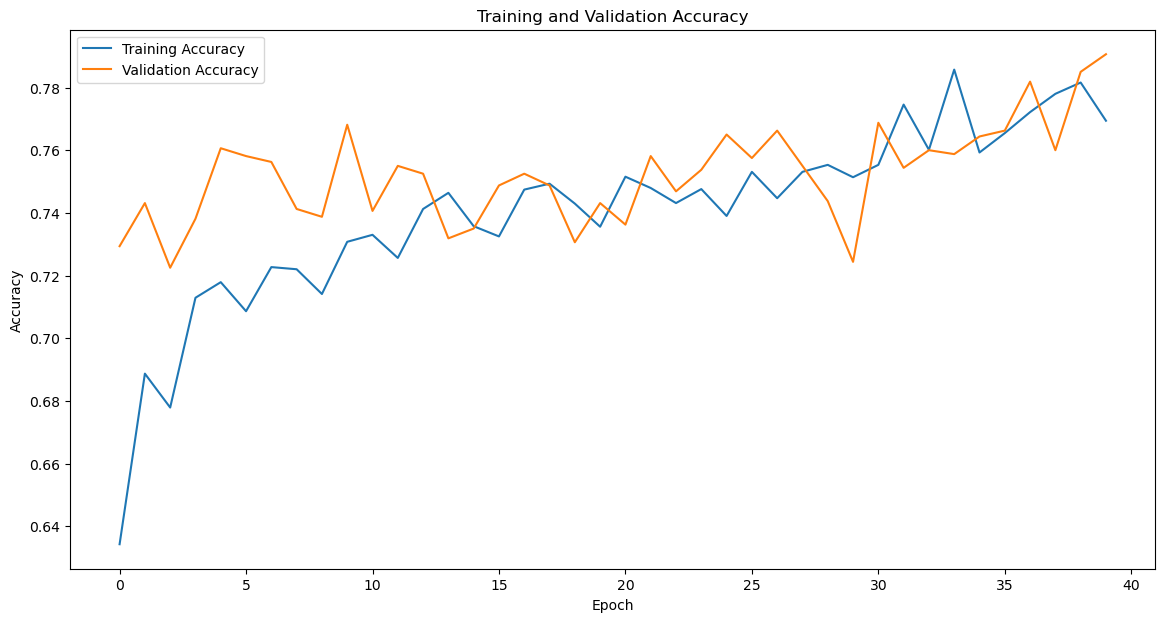

In [54]:
plot_training(history)

In [56]:
encoder.save('encoder_im_18.h5')

In [69]:
encoder = load_model('encoder_im_18.h5', compile=True)

X = VIX[['Close']].values

# y = pd.Series(np.log(X[:, 0])).diff(1).shift(-1).values
# # y = label_bounds(SPX['Close'].values, SPX['Close'].ewm(span=28, min_periods=28).std().values)
# y = y.astype(np.float32)
# y = np.where(y > 0, 1., 0)

y = pd.Series(np.log(X[:, 0])).diff(1).shift(-1).values
# y = label_bounds(SPX['Close'].values, SPX['Close'].ewm(span=28, min_periods=28).std().values)
y = y.astype(np.float32)
y = np.where(y > 0, 1., 0)

X = X[1:]
y = y[1:]

def compute_embeddings(x):
    x = window(x, timesteps, 1)
    xt = []
    for i in range(len(x)):
        img = np.zeros((height, timesteps, 1))
        xt.append(draw(img, scale(x[i])))
    return encoder.predict(np.array(xt))

features = compute_embeddings(X)
X = X[timesteps:]
y = y[timesteps:]

print(X.shape, features.shape)

265/265 [==============================] - 1s 2ms/step
(8472, 1) (8472, 32)


In [70]:
x_train, x_test, y_train, y_test = split(features, y, 0.25)

def rebalance(x, y):
    unique_labels, label_counts = np.unique(y, return_counts=True)
    min_samples = np.min(label_counts)
    idx = []
    for label in unique_labels:
        idx.extend(np.where(y == label)[0][:min_samples])
    np.random.shuffle(idx)
    return x[idx], y[idx]

x_train, y_train = rebalance(x_train, y_train)
x_test, y_test = rebalance(x_test, y_test)
assert(len(y_train[y_train > 0]) == len(y_train[y_train < 1]))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_train.dtype)

(5978, 32) (5978,) (1902, 32) (1902,) float32


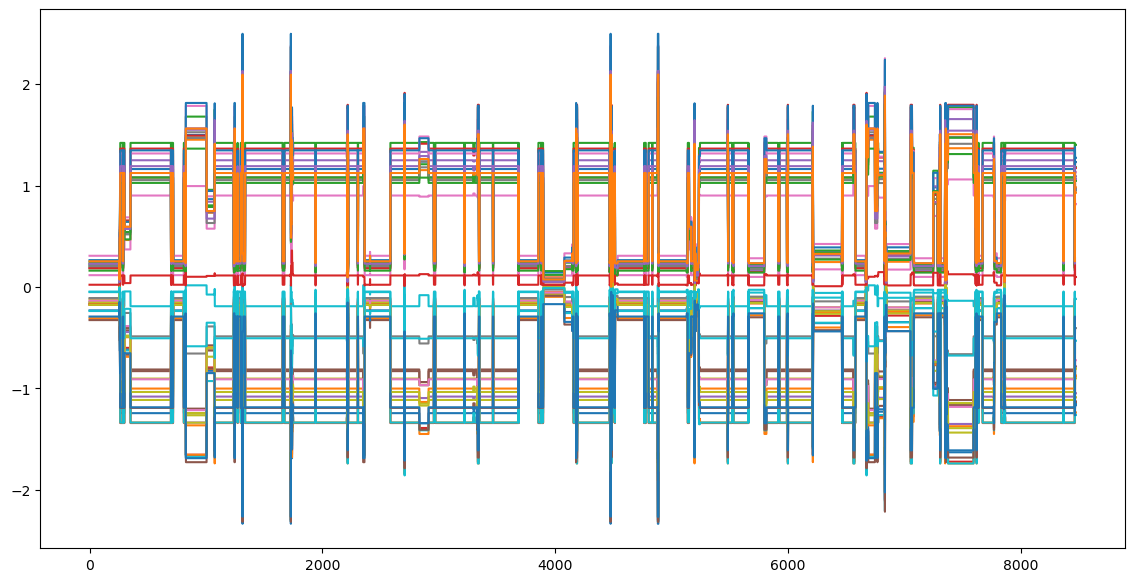

In [71]:
plot(features)

In [72]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Since it's a binary classification task
    n_estimators=2000,             # Number of boosting rounds (trees)
    learning_rate=0.01,            # Step size shrinkage
    max_depth=9,                  # Maximum tree depth
    use_label_encoder=False,      # Avoid label encoding warning
    eval_metric='logloss'         # Evaluation metric for binary classification
)

# Train the model
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 46.85%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      0.71      0.57       951
         1.0       0.44      0.23      0.30       951

    accuracy                           0.47      1902
   macro avg       0.46      0.47      0.44      1902
weighted avg       0.46      0.47      0.44      1902

Confusion Matrix:
[[674 277]
 [734 217]]


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Standardizing features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Optionally reduce dimensionality if you suspect multicollinearity
# pca = PCA(n_components=1)  # Reduce to 10 components
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', max_iter=2000)

# Train the model on the training data
model.fit(x_train, y_train)

# Predict on the test set
y_pred = model.predict(x_test)

# y_prob = model.predict_proba(x_test)[:, 1]  # Get probabilities for class 1
# y_pred = (y_prob > 0.4989020).astype(int)  # Adjust threshold if needed

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 43.74%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.44      0.45      0.44       951
         1.0       0.44      0.43      0.43       951

    accuracy                           0.44      1902
   macro avg       0.44      0.44      0.44      1902
weighted avg       0.44      0.44      0.44      1902

Confusion Matrix:
[[427 524]
 [546 405]]


In [74]:
# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

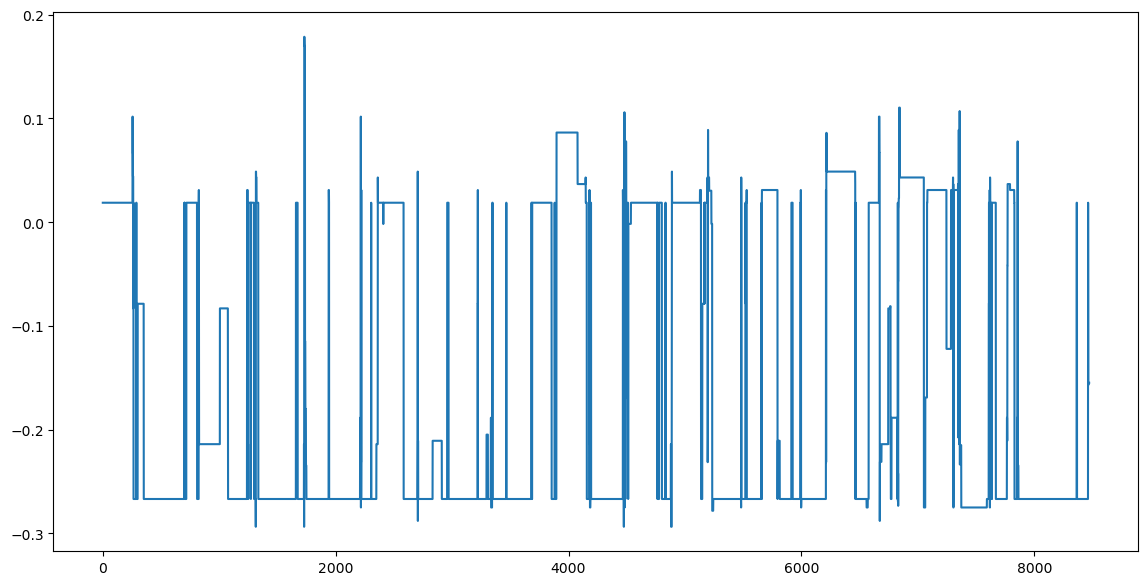

Test Set Sharpe Ratio: 0.1877
Benchmark Sharpe Ratio: -0.0110


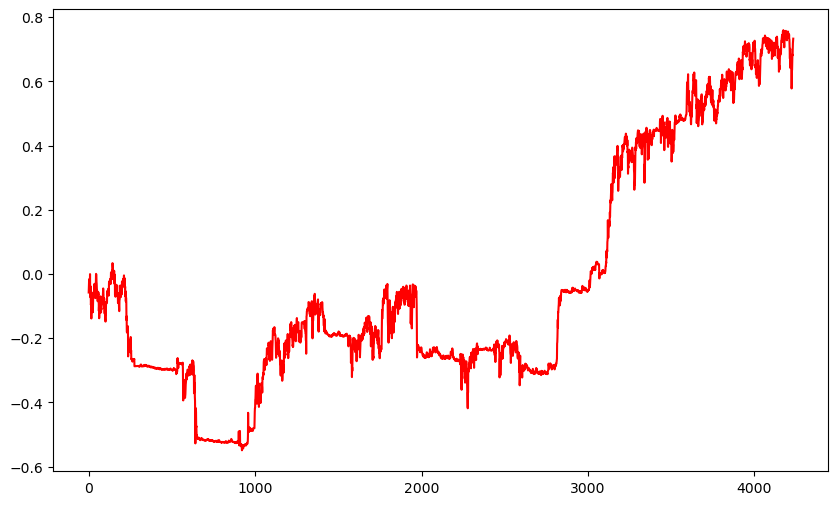

In [75]:
allocations = (model.predict_proba(features)[:, 1]) - 0.5
plot(allocations)
log_returns = returns(X[:, 0])

# Calculate the Sharpe ratio on the test set
portfolio_returns = log_returns * allocations[1:]

test_idx = int(len(log_returns) * 0.5)

print(f'Test Set Sharpe Ratio: {sharpe_ratio(portfolio_returns[-test_idx:]):.4f}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns[-test_idx:]):.4f}')

plt.figure(figsize=(10, 6))
# plt.plot(np.arange(test_idx), np.cumsum(log_returns[-test_idx:]), label='S&P', color='blue')
plt.plot(np.arange(test_idx), np.cumsum(portfolio_returns[-test_idx:]), label='Strategy', color='red')



In [36]:
history = fm.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_test, y_test))

NameError: name 'fm' is not defined

In [233]:
from sklearn.metrics import classification_report

y_pred = fm.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))

87/87 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.50      0.99      0.66      1384
         1.0       0.42      0.01      0.02      1384

    accuracy                           0.50      2768
   macro avg       0.46      0.50      0.34      2768
weighted avg       0.46      0.50      0.34      2768



In [76]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


# Define the model architecture
# def create_model(input_shape):
#     model = models.Sequential([
#         Input(input_shape),
#         Dense(32, activation='relu'),
#         Dense(16, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='tanh')  # Output is in the range (-1, 1)
#     ])
#     return model

def create_model(input_shape):
    inputs = Input(input_shape)
    x = Reshape((32,1))(inputs)
    x = Conv1D(32, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inputs, x)

# def create_model(input_shape):
#     model = models.Sequential()

#     # Reshape to treat features as a single timestep
#     model.add(Reshape((1, 32), input_shape=(32,)))

#     # LSTM Layer
#     model.add(LSTM(64, return_sequences=False))

#     # Dense Layers
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1, activation='tanh'))
#     return model


# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

# Custom training loop with gradient ascent for a single batch
def train_step(model, log_returns, features, optimizer):
    with tf.GradientTape() as tape:
        allocations = model(features, training=True)  # Forward pass
        portfolio_returns = tf.reduce_sum(log_returns * allocations, axis=1)
        sharpe = sharpe_ratio(portfolio_returns)
        loss = -sharpe  # Negative Sharpe ratio (to maximize it)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return sharpe


# Hyperparameters
window_size = 250
epochs_per_step = 1
learning_rate = 0.001

# Create the model
log_returns, x_features = returns(X[:, 0]), features[1:]
assert(len(log_returns) == len(x_features))

allocations = np.zeros_like(log_returns)
model = create_model(x_features.shape[1])
optimizer = optimizers.legacy.Adam(learning_rate=learning_rate)

# Rolling window online learning
for i in range(window_size, len(log_returns) - window_size, window_size):
    
    # Train the model up to the current window
    for epoch in range(epochs_per_step):
        sharpe = train_step(model, log_returns[:i], x_features[:i], optimizer)
    
    # Predict next window
    allocations[i:i+window_size] = model.predict(x_features[i:i+window_size])[:, 0]

    # Compute sharpe ratio achieved so far
    sharpe_test = sharpe_ratio(log_returns[:i+window_size] * allocations[:i+window_size])
    
    print(f'Step {i}/{len(log_returns)}, Train Sharpe: {sharpe:.4f}, Test Sharpe {sharpe_test:.4f}')

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Incompatible shapes: [250] vs. [250,64] [Op:Mul]

Test Set Sharpe Ratio: 0.3403
Benchmark Sharpe Ratio: 0.3341


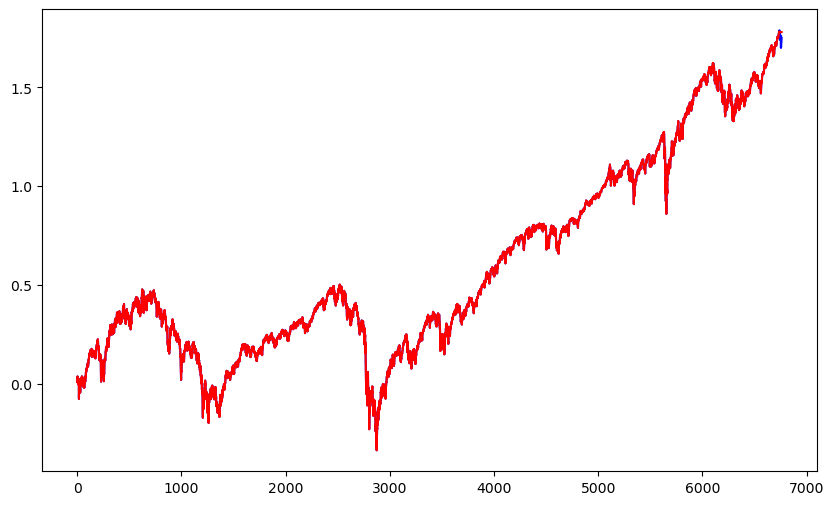

In [223]:
# Calculate the Sharpe ratio on the test set
portfolio_returns = log_returns * allocations

test_idx = int(len(log_returns) * 0.5)

print(f'Test Set Sharpe Ratio: {sharpe_ratio(portfolio_returns[-test_idx:]):.4f}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns[-test_idx:]):.4f}')

plt.figure(figsize=(10, 6))
plt.plot(np.arange(test_idx), np.cumsum(log_returns[-test_idx:]), label='S&P', color='blue')
plt.plot(np.arange(test_idx), np.cumsum(portfolio_returns[-test_idx:]), label='Strategy', color='red')

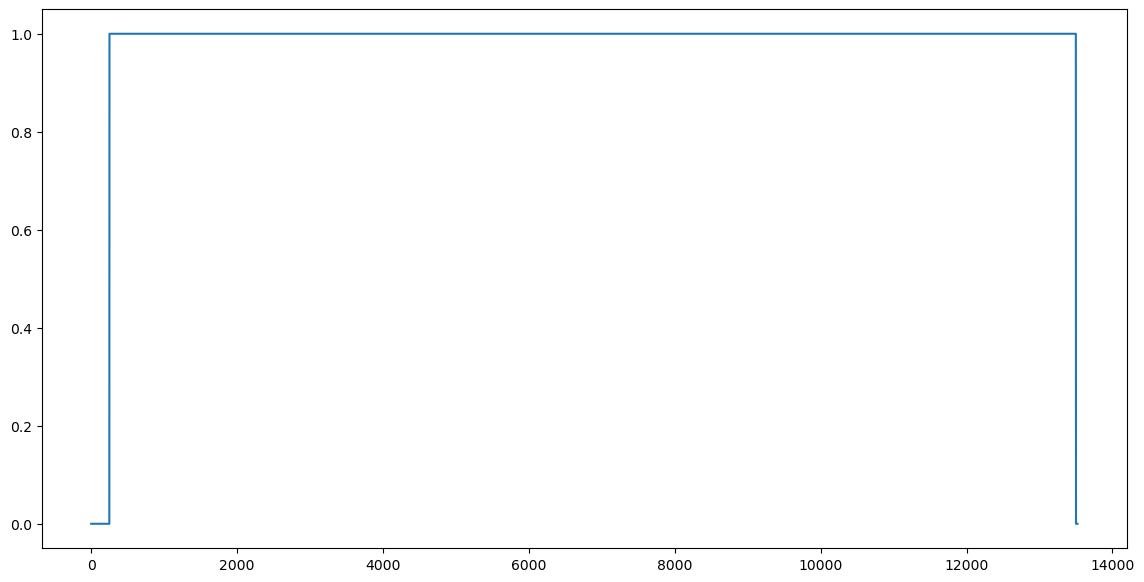

In [224]:
plot(allocations)